In [1]:
# Imports needed libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Reads the categories for each id from the json file
names = {}
with open('dataset/USA_categories.json') as file:
    cats = file.read()
    cats = json.loads(cats)

    for cat in cats['items']:
        names[cat['id']] = cat['snippet']['title']

# Reads the dataset into a dataframe using Pandas
df_all = pd.read_csv('dataset/USA_videos.csv')
df_all.drop_duplicates(inplace = True)

# Prepares the trending video data for analysis
df_all['category'] = df_all['category_id'].apply(lambda row: names[str(row)]) # Gets the category name from the id
df_all['tags'].replace('[none]', np.nan, inplace = True) # Removes [none] values
df_all['reactions'] = df_all['likes'] + df_all['dislikes']
df_all['liked%'] = df_all['likes'] / df_all['reactions'] * 100
df_all['liked%'].fillna(0, inplace = True)
df_all['liked%'] = df_all['liked%'].astype(int) # Converts to int from float for the sake of easier grouping
df_all['date'] = df_all['date'].apply(lambda row: pd.to_datetime(str(row) + '.2017', format = '%d.%m.%Y'))
df_all['day'] = df_all['date'].apply(lambda row: row.day_name()) # Gets the day of the week from the date

df_last = df_all.drop_duplicates(subset = ['video_id'], keep = 'last')

# For a simplified model keep only the data for the first day
df = df_all.drop_duplicates(subset = ['video_id'])

In [2]:
df.describe()

,category_id,views,likes,dislikes,comment_total,date,reactions,liked%
count,2364.000000,2.364000e+03,2.364000e+03,2364.000000,2364.000000,2364,2.364000e+03,2364.000000
mean,20.411168,5.490724e+05,2.362600e+04,876.478003,3256.198816,2017-05-17 16:38:59.086294272,2.450248e+04,91.590948
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,2017-01-01 00:00:00,0.000000e+00,0.000000
25%,17.000000,4.861575e+04,9.342500e+02,34.000000,157.000000,2017-01-11 00:00:00,1.076000e+03,93.000000
50%,24.000000,1.842250e+05,5.402000e+03,151.000000,706.000000,2017-09-13 00:00:00,5.828000e+03,97.000000
75%,25.000000,5.644862e+05,1.981175e+04,582.250000,2485.250000,2017-09-21 00:00:00,2.052800e+04,98.000000
max,43.000000,3.632350e+07,1.478119e+06,188836.000000,501435.000000,2017-09-30 00:00:00,1.524596e+06,100.000000
std,7.243902,1.337222e+06,7.030216e+04,4902.321030,13816.339544,NaN,7.257883e+04,15.585911


In [3]:
# The data implies that videos can trend several days even if they have 0 views
(df_all['views'] == 0).sum() / (df['views'] == 0).sum()

5.0

/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/pb/2j3qm5ms2sg07k2gzwxs07280000gq/T/ipykernel_95625/1737761712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last.loc[:, 'views_log'] = np.log(df_last['views'])
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/pb/2j3qm5ms2sg07k2gzwxs07280000gq/T/ipykernel_95625/1737761712.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

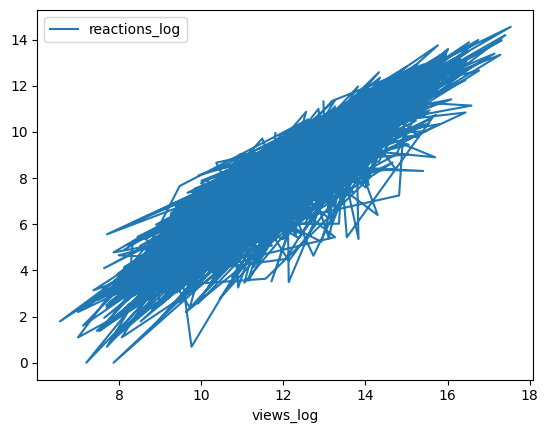

In [4]:
# Applies a natural logarithm transofrmation to normalize
df_last.loc[:, 'views_log'] = np.log(df_last['views'])
df_last.loc[:, 'reactions_log'] = np.log(df_last['reactions'])

# With more views there are generally more reactions
plot = df_last.plot.scatter(x = 'views_log', y = 'reactions_log')
plot.figure.savefig('report/images/corelation.jpg')

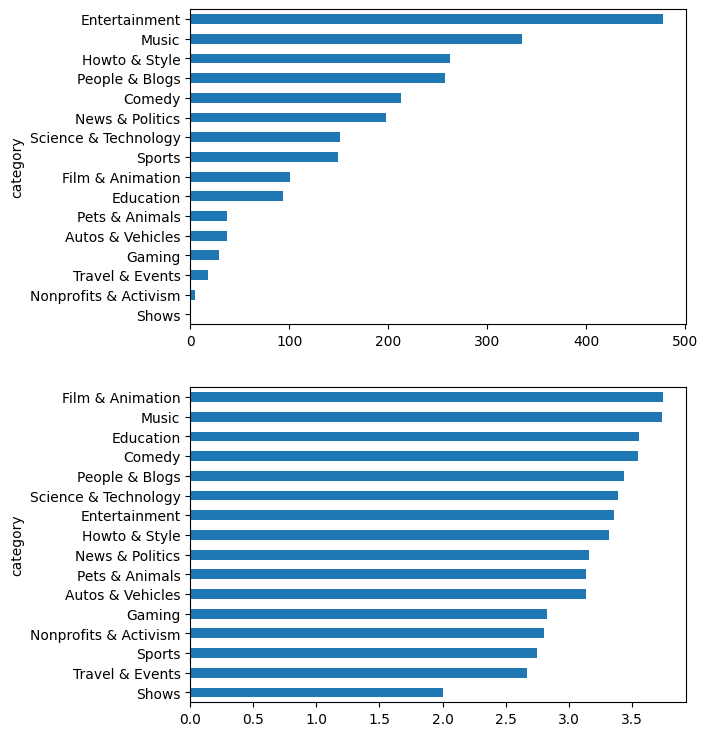

In [5]:
cats = df['category'].value_counts(ascending = True)
days = df_all['category'].value_counts() / cats

fig, axs = plt.subplots(nrows = 2, figsize = (6.4, 9))
axs[0].set_xlabel("Videos posted")
axs[1].set_xlabel("Days trended")

# The amount of videos posted within each category and how many days does does the average one trend
# The data indicates that Entertainment and Music
# are the most popular categories
cats.plot.barh(ax = axs[0])
days.sort_values().plot.barh(ax = axs[1])
fig.savefig('report/images/category.jpg')

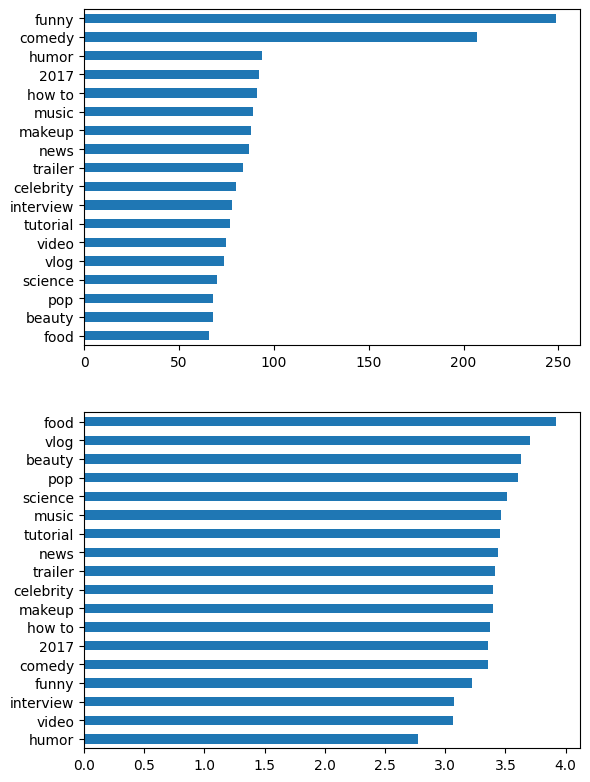

In [6]:
from collections import Counter

# Count how many times each tag occurs for each dataset given
# and ensure they each contain the same tags
def tags_c(*args, n = 20):
    res = []
    for arg in args:
        t_nums = Counter()
        for tags in arg['tags'].dropna():
            for each in tags.split('|'):
                each = each.lower()
                t_nums[each] += 1

        tags = pd.Series()

        # Makes the assumption that we will find the same tags in this many
        for tag in reversed(t_nums.most_common(n)):
            tags[tag[0]] = tag[1]

        res.append(tags)

    if len(args) > 1:
        # A rather lazy way to do an intersection
        temp = res[0].keys()
        for each in res[1:]:
            temp = temp.intersection(each.keys())

        # Remove any keys which arent common keys
        for i in range(len(res)):
            res[i] = res[i][temp]

        return res
    else:
        return res[0]

tags, days = tags_c(df, df_all)
days /= tags

fig, axs = plt.subplots(nrows = 2, figsize = (6.4, 9.6))
axs[0].set_xlabel("Videos posted")
axs[1].set_xlabel("Days trended")

# The ~20 most used tags and an estimated how many days do average videos with them trend
# The tag of the current year is relatively popular, it's harder to pinpoint exact videos
tags.plot.barh(ax = axs[0])
days.sort_values().plot.barh(ax = axs[1])
fig.savefig('report/images/tags.jpg')

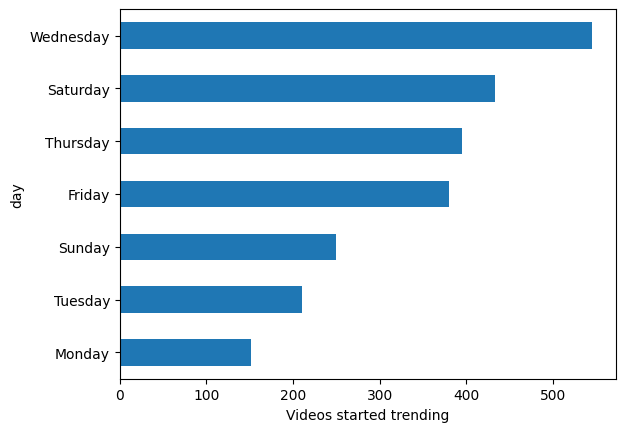

In [7]:
# On which day did videos start trending, the data indicates that
# people don't like Mondays and Tuesdays but Wednesday is
# the perfect day to start the effective week (until it ends on Sunday)
plot = df['day'].value_counts(ascending = True).plot.barh()
plot.set_xlabel("Videos started trending")
plot.figure.savefig('report/images/day.jpg')

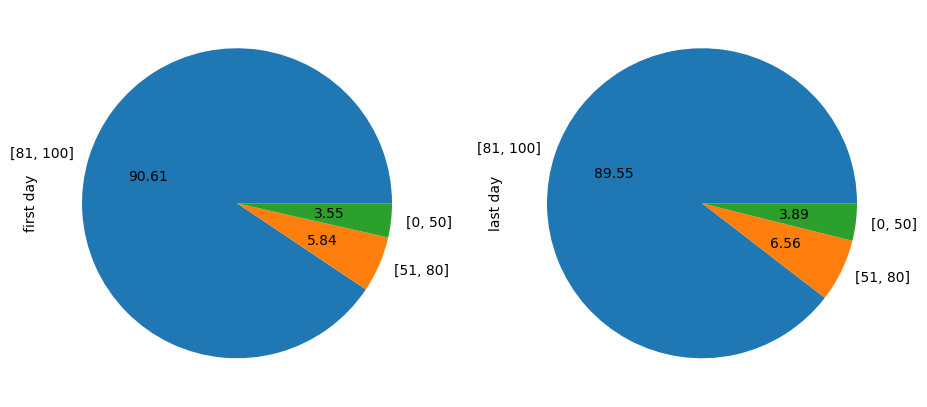

In [8]:
# Groups liked% values into 3 categories
def liked(data, name):
    bins = pd.IntervalIndex.from_tuples([(0, 50), (51, 80), (81, 100)], closed = 'both')
    percents = pd.cut(data['liked%'], bins)
    percents = percents.value_counts()
    percents.name = name

    return percents

fig, axs = plt.subplots(ncols = 2, figsize = (11, 11))
# The percent of likes from the video reactions on the first day they trended compared to the last
# The data indicates that most trending videos are liked
# but that controversial videos make it into trending as well
liked(df, 'first day').plot.pie(autopct = '%.2f', ax = axs[0])
liked(df_last, 'last day').plot.pie(autopct = '%.2f', ax = axs[1])
fig.savefig('report/images/liked.jpg')

/var/folders/pb/2j3qm5ms2sg07k2gzwxs07280000gq/T/ipykernel_95625/1926455042.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last['re_watches'] = df_last['views'] / df_last['reactions']
/var/folders/pb/2j3qm5ms2sg07k2gzwxs07280000gq/T/ipykernel_95625/1926455042.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last['re_watches'].replace(np.inf, np.nan, inplace = True)
/var/folders/pb/2j3qm5ms2sg07k2gzwxs07280000gq/T/ipykernel_95625/1926455042.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

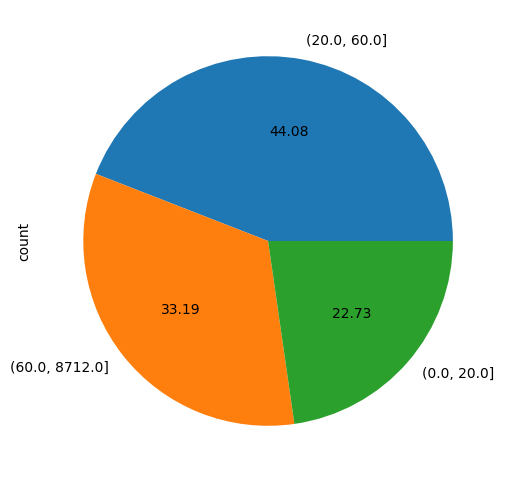

In [9]:
# Estimates the number of re watches by dividing the views by the reactions
df_last['re_watches'] = df_last['views'] / df_last['reactions']
df_last['re_watches'].replace(np.inf, np.nan, inplace = True)
df_last['re_watches'].fillna(0, inplace = True)

temp = pd.IntervalIndex.from_tuples([(0, 20), (20, 60), (60, df_last['re_watches'].max())])
temp = pd.cut(df_last['re_watches'], temp)
temp = temp.value_counts()

# Most trending videos are re watched many times
plot = temp.plot.pie(autopct = '%.2f', figsize = (6, 6))
plot.figure.savefig('report/images/re_watches.jpg')

/var/folders/pb/2j3qm5ms2sg07k2gzwxs07280000gq/T/ipykernel_95625/246152650.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last['sentiment'] = df_last['video_id'].apply(sentiment)


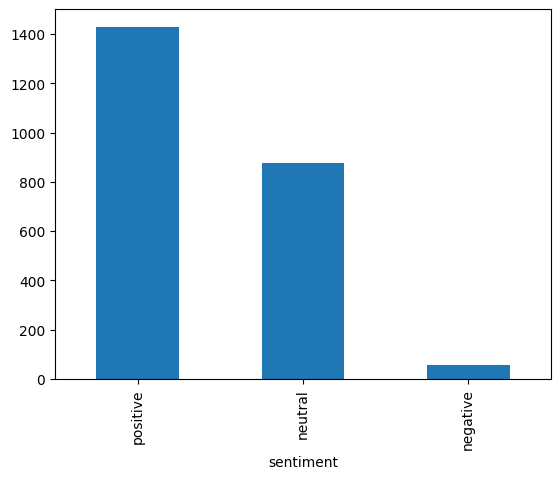

In [14]:
# Comment sentiment analysis, would highly benefit from multi-threading
from textblob import TextBlob
from re import compile

# Loads the comments file
df_comments = pd.read_csv('dataset/USA_comments.csv', low_memory=False)
df_comments.dropna(inplace = True)

# Removes special characters, links, ...
reg = compile('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)')
def clean(comment):
    return ' '.join(reg.sub(' ', comment).split())

def sentiment(video_id):
    counter = {'positive':0, 'neutral':0, 'negative':0}
    # Gets all rows where the video_id is the one given to this function
    comments = df_comments.loc[df_comments['video_id'] == video_id]

    for each in comments['comment_text']:
        temp = clean(each)
        # Creates a TextBlob instance with each comment, uses NLTK corpora
        temp = TextBlob(temp)

        # Checks what the calculated polarity is and increases the adequate counter
        if temp.sentiment.polarity > 0: 
            counter['positive'] += 1
        elif temp.sentiment.polarity == 0: 
            counter['neutral'] += 1
        else: 
            counter['negative'] += 1

    # Returns the key with the highest value
    return max(counter, key = counter.get)

df_last['sentiment'] = df_last['video_id'].apply(sentiment)
temp = df_last['sentiment'].value_counts()

# The results are not fully accurate but reaffirm the idea that most videos are
# very liked but that controversial ones make it into trending as well
plot = temp.plot.bar()
plot.figure.savefig('report/images/comments.jpg')

In [20]:
from math import log
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM

# scikit works only with numeric data
# Simulates a one hot encoder but with weighted values
def func(row):
    for tag in row['tags'].split('|'):
        tag = tag.lower()
        if tag in tags:
            row[tag] = log(tags[tag])

    return row

model = OneClassSVM(gamma = 'auto') # nu?
df_temp = df[['category_id', 'tags', 'views', 'reactions', 'liked%']].dropna()

# Handling outliers
df_temp = df_temp.loc[df_temp['views'] > df_temp['views'].quantile(0.002)]
# If df_temp['views'] > df_temp['views'].quantile(0.1) give mean reactions and liked values
df_temp = df_temp.loc[df_temp['reactions'] > df_temp['reactions'].quantile(0.01)]
df_temp = df_temp.loc[df_temp['liked%'] > df_temp['liked%'].quantile(0.009)]
temp = np.log(df_temp['category_id'].value_counts())

# Tries several values and reports the one with the best results
accuracy = 0; number = 0
for num in range(1, 20):
    # Keeps only the columns relevant for predictive machine learning
    # and drops any rows from them that contain nan values
    df_t = df_temp[['category_id', 'tags']]

    # Calls the tags_c function from the tags calculator cell
    tags = tags_c(df_t, n = num)

    # Assumes a video doesn't have the num most used tags
    for tag in tags.keys():
        df_t[tag] = 0

    # Gives weighted values to the most used categories
    df_t['category_id'] = df_t['category_id'].apply(lambda row: temp[row])
    df_t = df_t.apply(func, axis = 1)
    df_t.drop('tags', axis = 1, inplace = True)

    # Splits the dataset, 80% for training and 20% for testing
    X_train, X_test = train_test_split(df_t, test_size = 0.2, random_state = 0)

    # Trains the model
    model.fit(X_train)
    res = model.predict(X_test) # Determines if X_test data is similar to X_train
    res = res[res == 1].size / X_test.shape[0] # Calculates the accuracy by seeing how many predictions are right

    if res > accuracy:
        accuracy = res
        number = num

print('Accuracy:', accuracy * 100, '\nNumber of tags:', number)

/var/folders/pb/2j3qm5ms2sg07k2gzwxs07280000gq/T/ipykernel_95625/2136427215.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t[tag] = 0
/var/folders/pb/2j3qm5ms2sg07k2gzwxs07280000gq/T/ipykernel_95625/2136427215.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['category_id'] = df_t['category_id'].apply(lambda row: temp[row])
/var/folders/pb/2j3qm5ms2sg07k2gzwxs07280000gq/T/ipykernel_95625/2136427215.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

Accuracy: 69.5852534562212 
Number of tags: 6
